In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy import inf
import itertools
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import warnings
import statistics

# Part 1: Optimization


## Import dataset

In [ ]:
diabetes_test=pd.read_csv("/content/drive/My Drive/551A2/diabetes/diabetes_test.csv",index_col=False)
diabetes_train=pd.read_csv("/content/drive/My Drive/551A2/diabetes/diabetes_train.csv",index_col=False)
diabetes_val=pd.read_csv("/content/drive/My Drive/551A2/diabetes/diabetes_val.csv",index_col=False)
diabetes_val


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,12,140,85,33,0,37.4,0.244,41,0
1,0,108,68,20,0,27.3,0.787,32,0
2,3,74,68,28,45,29.7,0.293,23,0
3,7,129,68,49,125,38.5,0.439,43,1
4,7,133,88,15,155,32.4,0.262,37,0
...,...,...,...,...,...,...,...,...,...
95,1,131,64,14,415,23.7,0.389,21,0
96,7,114,76,17,110,23.8,0.466,31,0
97,8,196,76,29,280,37.5,0.605,57,1
98,4,144,58,28,140,29.5,0.287,37,0


## 1. Apply Logistic Regression


In [ ]:
#Logistic Regression
%matplotlib inline


Text(0.5, 1.0, 'logistic function')

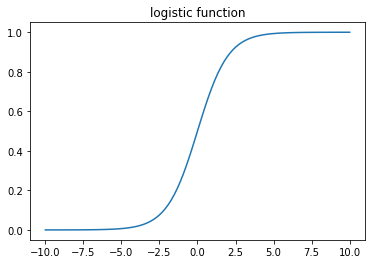

In [ ]:
#logistic function
logistic = lambda z: 1./ (1 + np.exp(-z))
z = np.linspace(-10,10,100)
plt.plot(z, logistic(z))
plt.title('logistic function')

In [ ]:
def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

In [ ]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

In [ ]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, record_history=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.record_history = record_history
        if record_history:
            self.history = []

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        prev_g = -np.inf
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            if self.record_history:
              self.history.append(self.w) 
            t += 1
            prev_g = g
 
      ####
        if self.verbose:
            if (np.linalg.norm(g) > self.epsilon):
              print(f'warning: gradient not fully converged, increase max_iters ')
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

In [ ]:
#fit model and predict
X_train = diabetes_train.iloc[:,0:-1]
X_test = diabetes_val.iloc[:,0:-1]
y_train = diabetes_train['Outcome']
y_test = diabetes_val['Outcome']

### Base Model

In [ ]:
model = LogisticRegression(verbose=True,)
model.fit(X_train,y_train)
yh=model.predict(X_test)
yh = np. around(yh, 0)

cnf_matrix = confusion_matrix(y_test, yh)
print(cnf_matrix)
validation_accuracy = np.mean(yh == y_test)
print(validation_accuracy)


terminated after 100000 iterations, with norm of the gradient equal to 67.21373295988212
the weight found: [  55.80593107    6.8584975    -8.47072289   -1.67467507    2.79258163
    2.38460908   55.2282653    -3.58139464 -323.94214352]
[[25 40]
 [ 7 28]]
0.53


Text(0.5, 257.44, 'Predicted label')

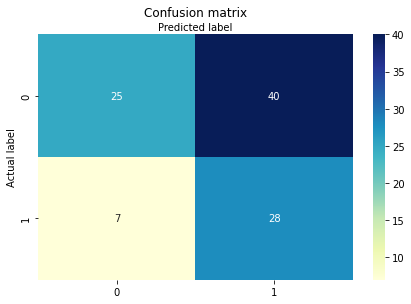

In [ ]:
#Visualize confusin matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
#tick_marks = np.arange(len(class_names))
#plt.xticks(tick_marks, class_names)
#plt.yticks(tick_marks, class_names)
#create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Find best parameters

In [ ]:
warnings.filterwarnings('ignore')
learning_rates=[]## learnign rates [1e-6 to 1e-1]
for i in range(1, 7):
  n = pow(10, -i)
  learning_rates.append(n) 
training_iters = [1e2, 1e3, 1e4, 1e5, 1e6]

best_learning_rates=learning_rates[0]
best_training_iters=training_iters[0]
best_accuracy=0

tot_accuracy=[]
tot_training_accuracy=[]
for i in training_iters:
  print('---------------------------')
  print(f'Training_iters={i}')
  val_accuracy_list=[]
  train_accuracy_list=[]
  for j in learning_rates:

    model = LogisticRegression(learning_rate=j, max_iters=i)
    model.fit(X_train,y_train)
    yh=model.predict(X_test)
    yh = np. around(yh, 0)
    validation_accuracy = np.mean(yh == y_test)

    yt= np.around(model.predict(X_train), 0)
    training_accuracy = np.mean(yt == y_train)

    if validation_accuracy>best_accuracy:
      best_learning_rates=j
      best_training_iters=i
      best_accuracy = validation_accuracy

    val_accuracy_list.append(validation_accuracy)
    train_accuracy_list.append(training_accuracy)
  tot_accuracy.append(val_accuracy_list)
  tot_training_accuracy.append(train_accuracy_list)






---------------------------
Training_iters=100.0
---------------------------
Training_iters=1000.0
---------------------------
Training_iters=10000.0
---------------------------
Training_iters=100000.0
---------------------------
Training_iters=1000000.0


In [ ]:
def showPlot_lr(learning_rate_list, tot_accuracy, training_iters):
    plt.xlabel("Learning_rates")
    plt.ylabel("Accuracy")
    plt.xscale("log")
    for t in tot_accuracy:
      i = tot_accuracy.index(t)
      plt.plot(learning_rate_list, t, label=f"max_iter={int(training_iters[i])}") 
    plt.legend()
    plt.show()

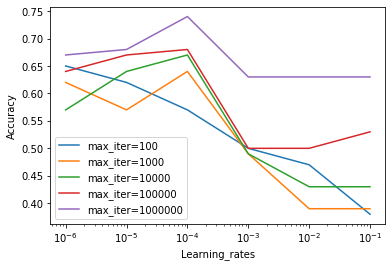

In [ ]:
tot_accuracy
showPlot_lr(learning_rates, tot_accuracy,training_iters)

Best Parameters: Learning Rate = 0.0001, Training Iters = 1000000.0


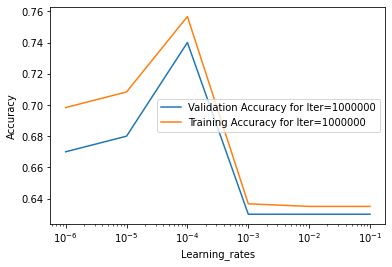

In [ ]:
print(f'Best Parameters: Learning Rate = {best_learning_rates}, Training Iters = {best_training_iters}')

## show convergence of training/validation accuracy with best iters
plt.xlabel("Learning_rates")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.plot(learning_rates, tot_accuracy[training_iters.index(best_training_iters)], label=f"Validation Accuracy for Iter={int(best_training_iters)}") 
plt.plot(learning_rates, tot_training_accuracy[training_iters.index(best_training_iters)], label=f"Training Accuracy for Iter={int(best_training_iters)}") 

plt.legend()
plt.show()
## Best Parameters: Learning Rate = 0.0001, Training Iters = 1000000.0
## note: training and validation distance shortened as learning rate approaches 0 --> converging 

### Test Accuracy

In [ ]:
X_TEST = diabetes_test.iloc[:,0:-1]
Y_TEST = diabetes_test['Outcome']

model = LogisticRegression(learning_rate=best_learning_rates, max_iters=1e6)
model.fit(X_train,y_train)

yh=model.predict(X_TEST)
yh = np. around(yh, 0)
test_accuracy = np.mean(yh == Y_TEST)

validation_accuracy = np.mean(yh == Y_TEST)

print(f'Test Accuracy with best parameters: {test_accuracy}')
cnf_matrix = confusion_matrix(Y_TEST, yh)
print(cnf_matrix)

#Test Accuracy with best parameters: 0.7352941176470589

NameError: ignored

## 2. Mini-batch stochastic gradient descent


In [ ]:
def gradient_for_minibatch(w, x, y):
  #print(x.shape)
  N,D = x.shape
  yh = logistic(np.dot(x,w))          # predictions  size N
  grad = np.dot(x.transpose(), yh - y) / N        # divide by N because cost is mean over N points
  #print(grad)
  return grad                         # size D

In [ ]:
def minibatch_grad (data, x, y, X_test, y_test, learning_rate = 0.0001, batch_size = 20, max_iters = 100, epsilon = 1e-4, add_bias=True):
  w = np.zeros((x.shape[1])+(1 if add_bias else 0))
  previous_cost = -inf
  t = 0
  val_accuracy = []
  train_accuracy = []
  times = []
  if (add_bias):
    N = x.shape[0]
    x = np.column_stack([np.ones(N),x])
    data = pd.DataFrame(np.column_stack([np.ones(N),data]))
  while t < max_iters: 
    batches = create_mini_batches(data, x, y, batch_size)
    time_start = time.process_time()
    for batch in batches:
        X_mini, y_mini = batch
        if X_mini.empty == False:
          w = w - learning_rate * gradient_for_minibatch(w, X_mini, y_mini)
          g = gradient_for_minibatch(w, x,y)
          #print(np.linalg.norm(g))
          '''
          if (np.linalg.norm(g) < epsilon):
            print("Converged")
            t = max_iters+1
            break
          '''
    time_end = time.process_time() - time_start
    times.append(time_end)
    yh_test = np.round(logistic(np.dot(X_test,w)),0)
    val_accuracy.append(np.mean(yh_test == y_test))
    yh_train = np.round(logistic(np.dot(x,w)),0)
    train_accuracy.append(np.mean(yh_train == y))
    t += 1
  time_avg = statistics.mean(times)
  print("Time used to process one epoch on average:", time_avg)
  return w, val_accuracy, train_accuracy, time_avg

In [ ]:
def create_mini_batches(data, X, y, batch_size):
    mini_batches = []
    data = data.sample(frac = 1)
    #data = np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    i = 0
    for i in range(n_minibatches + 1):
        mini_batch = data.iloc[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch.iloc[:, :-1]
        Y_mini = mini_batch.iloc[:, -1]#.reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data.iloc[i * batch_size:data.shape[0]]
        X_mini = mini_batch.iloc[:, :-1]
        Y_mini = mini_batch.iloc[:, -1]#.reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    return mini_batches
    

In [ ]:
def val_train_plot(val_accuracy,train_accuracy):
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.plot(val_accuracy, label = "Validation")
  plt.plot(train_accuracy, label = "Training")
  plt.legend()
  plt.show()

In [ ]:
#Only execute when add_bias = True
N = X_test.shape[0]
X_test = np.column_stack([np.ones(N),X_test])

Time used to process one epoch on average: 0.0010305204166669076


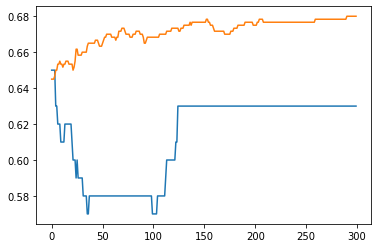

In [ ]:
#Full batch:
w, val_accuracy, train_accuracy, t_full = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=600, max_iters=300)
plt.plot(val_accuracy, label = "Validation")
plt.plot(train_accuracy, label = "Training")
plt.show()

In [ ]:
t0 = time.process_time()
w_full, val_accuracy, train_accuracy,t_full = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=600, max_iters=125)
t1_full = time.process_time() - t0
print("Time used for convergence:", t1_full)

Time used to process one epoch on average: 0.0010142424159996608
Time used for convergence: 0.3190685860000002


In [ ]:
w_6, val_accuracy, train_accuracy,t_6 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=6, max_iters=500)

Time used to process one epoch on average: 0.08971362832600009


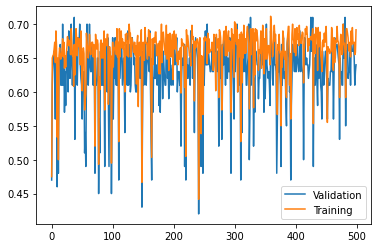

In [ ]:
val_train_plot(val_accuracy,train_accuracy)

In [ ]:
w_6, val_accuracy, train_accuracy,t_6 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=6, max_iters=20)
X_TEST = diabetes_test.iloc[:,0:-1]
Y_TEST = diabetes_test['Outcome']
N = X_TEST.shape[0]
X_TEST = np.column_stack([np.ones(N),X_TEST])
yh = np.round(logistic(np.dot(X_TEST,w_6)),0)
test_accuracy_6 = np.mean(yh == Y_TEST)
print(test_accuracy_6)

Time used to process one epoch on average: 0.08921178469999944
0.75


Time used to process one epoch on average: 0.04449300877000049


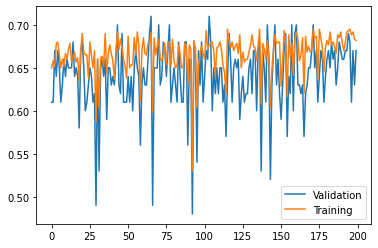

In [ ]:
w_12, val_accuracy, train_accuracy,t_12 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=12, max_iters=200)
val_train_plot(val_accuracy,train_accuracy)

In [ ]:
t0 = time.process_time()
w_12, val_accuracy, train_accuracy,t_12 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=12, max_iters=25)
t1_12 = time.process_time() - t0
print("Time used for convergence:", t1_12)

Time used to process one epoch on average: 0.04578234648000148
Time used for convergence: 1.431140217999996


In [ ]:
X_TEST = diabetes_test.iloc[:,0:-1]
Y_TEST = diabetes_test['Outcome']
N = X_TEST.shape[0]
X_TEST = np.column_stack([np.ones(N),X_TEST])
yh = np.round(logistic(np.dot(X_TEST,w_12)),0)
test_accuracy_12 = np.mean(yh == Y_TEST)
print(test_accuracy_12)

0.6911764705882353


Time used to process one epoch on average: 0.027015327824999814


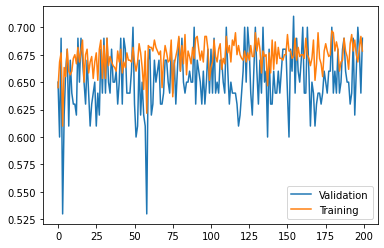

In [ ]:
w_20, val_accuracy, train_accuracy,t_20 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=20, max_iters=200)
val_train_plot(val_accuracy,train_accuracy)

Time used to process one epoch on average: 0.018539268390000245


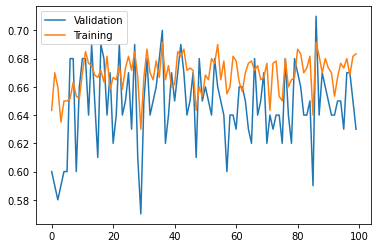

In [ ]:
w_30, val_accuracy, train_accuracy,t_30 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=30, max_iters=100)
val_train_plot(val_accuracy,train_accuracy)

In [ ]:
t0 = time.process_time()
w_30, val_accuracy, train_accuracy,t_30 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=30, max_iters=30)
t1_30 = time.process_time() - t0
print("Time used for convergence:", t1_30)

Time used to process one epoch on average: 0.018970413766667586
Time used for convergence: 0.7370316909999985


In [ ]:
X_TEST = diabetes_test.iloc[:,0:-1]
Y_TEST = diabetes_test['Outcome']
N = X_TEST.shape[0]
X_TEST = np.column_stack([np.ones(N),X_TEST])
yh = np.round(logistic(np.dot(X_TEST,w_30)),0)
test_accuracy_30 = np.mean(yh == Y_TEST)
print(test_accuracy_30)

0.6911764705882353


In [ ]:
w_50, val_accuracy, train_accuracy,t_50 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=50, max_iters=100)
#y_minibatch_predict_50 = logistic(np.dot(X_test,w_50))

Time used to process one epoch on average: 0.010729263649998018


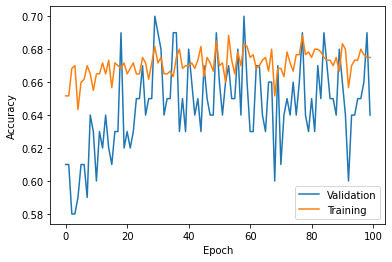

In [ ]:
val_train_plot(val_accuracy,train_accuracy)

In [ ]:
t0 = time.process_time()
w_50, val_accuracy, train_accuracy,t_50 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=50, max_iters=20)
t1_50 = time.process_time() - t0
print("Time used for convergence:", t1_50)

Time used to process one epoch on average: 0.010706626950000953
Time used for convergence: 0.2934768010000255


Time used to process one epoch on average: 0.005686446079999285


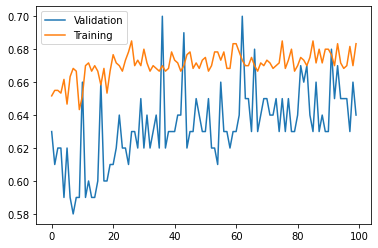

In [ ]:
w_100, val_accuracy, train_accuracy,t_100 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=100, max_iters=100)
val_train_plot(val_accuracy,train_accuracy)

In [ ]:
t0 = time.process_time()
w_100, val_accuracy, train_accuracy,t_100 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=100, max_iters=20)
t1_100 = time.process_time() - t0
print("Time used for convergence:", t1_100)

Time used to process one epoch on average: 0.005593852199999106
Time used for convergence: 0.16868412799999533


In [ ]:
X_TEST = diabetes_test.iloc[:,0:-1]
Y_TEST = diabetes_test['Outcome']
N = X_TEST.shape[0]
X_TEST = np.column_stack([np.ones(N),X_TEST])
yh = np.round(logistic(np.dot(X_TEST,w_100)),0)
test_accuracy_100 = np.mean(yh == Y_TEST)
print(test_accuracy_100)

0.7058823529411765


In [ ]:
#Apply on test data with batch size=50
w_50, val_accuracy, train_accuracy, t_50 = minibatch_grad(diabetes_train, X_train, y_train, X_test, y_test, batch_size=50, max_iters=20)
X_TEST = diabetes_test.iloc[:,0:-1]
Y_TEST = diabetes_test['Outcome']
N = X_TEST.shape[0]
X_TEST = np.column_stack([np.ones(N),X_TEST])
yh = np.round(logistic(np.dot(X_TEST,w_50)),0)
test_accuracy_50 = np.mean(yh == Y_TEST)
print(test_accuracy_50)

Time used to process one epoch on average: 0.011520302149999394
0.6911764705882353


No handles with labels found to put in legend.


[0.08921178469999944, 0.04578234648000148, 0.027015327824999814, 0.018970413766667586, 0.01111857759999708, 0.005593852199999106, 0.0010142424159996608]


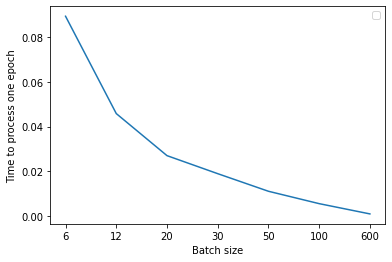

In [ ]:
sizes = ['6','12','20','30','50','100','600']
time_epoch = [t_6,t_12,t_20,t_30,t_50,t_100,t_full]
print(time_epoch)
plt.plot(sizes,time_epoch)
plt.xlabel("Batch size")
plt.ylabel("Time to process one epoch")
plt.legend()
plt.show()

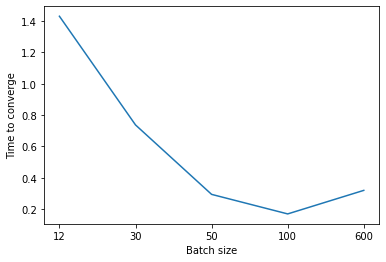

In [ ]:
sizes2 = ['12', '30', '50', '100','600']
time_converge = [t1_12,t1_30,t1_50,t1_100,t1_full]
plt.plot(sizes2,time_converge)
plt.xlabel("Batch size")
plt.ylabel("Time to converge")
plt.show()

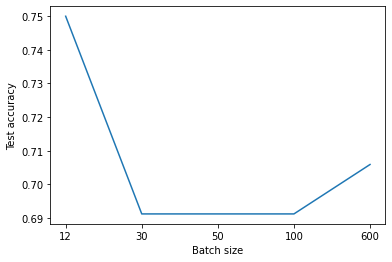

In [ ]:
sizes3 = ['6','12', '30', '50', '100']
acc_converge = [test_accuracy_6,test_accuracy_12,test_accuracy_30,test_accuracy_50,test_accuracy_100]
plt.plot(sizes2,acc_converge)
plt.xlabel("Batch size")
plt.ylabel("Test accuracy")
plt.show()

## 3. Add Momentum


In [ ]:
def momentum_fullbatch (data, x, y, X_test, y_test, beta = 0.99, learning_rate = 0.0001, max_iters = 300, epsilon =1e-4):
  w = np.zeros((x.shape[1]))
  g = np.inf 
  t = 0
  momentum = w 
  val_accuracy = []
  train_accuracy = []
  while t < max_iters:
    g = gradient_for_minibatch(w,x,y)
    momentum = beta * momentum + (1-beta) * g
    w = w - learning_rate * momentum
    yh_test = np.round(logistic(np.dot(X_test,w)),0)
    val_accuracy.append(np.mean(yh_test == y_test))
    yh_train = np.round(logistic(np.dot(x,w)),0)
    train_accuracy.append(np.mean(yh_train == y))
    '''
    if (np.linalg.norm(g) < epsilon):
      print("Converged")
      break
    '''
    #print(g)
    t += 1
  return w, val_accuracy, train_accuracy

In [ ]:
X_train = diabetes_train.iloc[:,0:-1]
X_test = diabetes_val.iloc[:,0:-1]
y_train = diabetes_train['Outcome']
y_test = diabetes_val['Outcome']

In [ ]:
#Find w and apply on validation data
t0 = time.process_time()
w, val_accuracy, train_accuracy = momentum_fullbatch(diabetes_train, X_train, y_train, X_test, y_test)
t1 = time.process_time() - t0
print("Time used after adding momentum to the full batch:", t1)
print(w)

Time used after adding momentum to the full batch: 0.6263038619999861
[ 4.63673910e-03  1.54555667e-02 -3.03224773e-02 -6.51135519e-03
  8.92786768e-04 -5.40756994e-03  6.11600555e-05  5.12840641e-04]


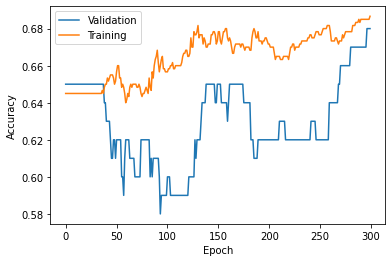

In [ ]:
val_train_plot(val_accuracy,train_accuracy)

In [ ]:
t0 = time.process_time()
w, val_accuracy, train_accuracy = momentum_fullbatch(diabetes_train, X_train, y_train, X_test, y_test, max_iters=40)
t1 = time.process_time() - t0
print("Time used for convergence:",t1)

Time used for convergence: 0.08547897699997975


In [ ]:
#Apply on test data
X_TEST = diabetes_test.iloc[:,0:-1]
Y_TEST = diabetes_test['Outcome']
yh = np.round(logistic(np.dot(X_TEST,w)),0)
test_accuracy = np.mean(yh == Y_TEST)
print(test_accuracy)

0.7058823529411765


Time used after adding momentum to the full batch: 0.6444264320000457
[ 0.00674144  0.01168214 -0.02665538 -0.00403656  0.00156214 -0.0048522
  0.00011984  0.00153257]


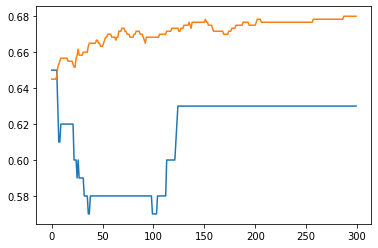

In [ ]:
#Changing beta to 0.6
t0 = time.process_time()
w_beta, val_accuracy6, train_accuracy6 = momentum_fullbatch(diabetes_train, X_train, y_train, X_test, y_test, beta=0.6)
t1 = time.process_time() - t0
print("Time used after adding momentum to the full batch:", t1)
print(w_beta)
plt.plot(val_accuracy6)
plt.plot(train_accuracy6)

In [ ]:
t0 = time.process_time()
w_beta6, val_accuracy, train_accuracy = momentum_fullbatch(diabetes_train, X_train, y_train, X_test, y_test, beta = 0.6, max_iters=120)
t1 = time.process_time() - t0
print("Time used for convergence:",t1)
yh6 = np.round(logistic(np.dot(X_TEST,w_beta6)),0)
test_accuracy6 = np.mean(yh6 == Y_TEST)
print(test_accuracy6)

Time used for convergence: 0.24239312499992138
0.6764705882352942


Time used after adding momentum to the full batch: 0.6201273950000541
[ 0.00676716  0.01166015 -0.02662481 -0.00402409  0.00156258 -0.00484939
  0.00012055  0.00153754]


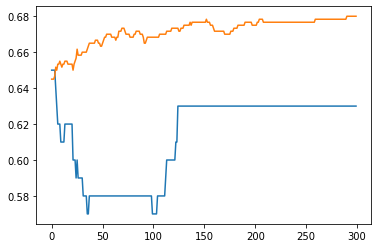

In [ ]:
#Changing beta to 0.2
t0 = time.process_time()
w_beta, val_accuracy2, train_accuracy2 = momentum_fullbatch(diabetes_train, X_train, y_train, X_test, y_test, beta=0.2)
t1 = time.process_time() - t0
print("Time used after adding momentum to the full batch:", t1)
print(w_beta)
plt.plot(val_accuracy2)
plt.plot(train_accuracy2)

In [ ]:
t0 = time.process_time()
w, val_accuracy, train_accuracy = momentum_fullbatch(diabetes_train, X_train, y_train, X_test, y_test, beta = 0.2, max_iters=120)
t1 = time.process_time() - t0
print("Time used for convergence:",t1)
yh = np.round(logistic(np.dot(X_TEST,w)),0)
test_accuracy = np.mean(yh == Y_TEST)
print(test_accuracy)

Time used for convergence: 0.2566393289999951
0.6764705882352942


## 4. Repeat with smallest/largest batch size



In [ ]:
def momentum_minibatch(data, x, y, beta = 0.99, learning_rate = 0.01, batch_size = 20, max_iters = 300, epsilon = 1e-4, add_bias=False):
  w = np.zeros(x.shape[1] + (1 if add_bias else 0))
  previous_cost = -inf
  t = 0
  momentum = w
  times = []
  val_accuracy = []
  train_accuracy = []
  while t < max_iters:# and np.linalg.norm(g) > epsilon:#for i in range(max_iters):
    batches = create_mini_batches(data, x, y, batch_size)
    t_start = time.process_time()
    for batch in batches:
      X_mini, y_mini = batch
      if X_mini.empty == False:
        g = gradient_for_minibatch(w,X_mini,y_mini)
        momentum = beta * momentum + (1-beta) * g
        w = w - learning_rate * momentum
    t_end = time.process_time()-t_start
    times.append(t_end)
    yh_test = np.round(logistic(np.dot(X_test,w)),0)
    val_accuracy.append(np.mean(yh_test == y_test))
    yh_train = np.round(logistic(np.dot(x,w)),0)
    train_accuracy.append(np.mean(yh_train == y))
    t += 1
  time_avg = statistics.mean(times)
  print("Time used to process one epoch on average:", time_avg)
  return w, val_accuracy, train_accuracy

Time used to process one epoch on average: 0.08333146785333573
[ 2.20186758 -0.03206125 -0.10425203  0.23016325 -0.02962065  0.09265867
  1.74787852  0.00391901]


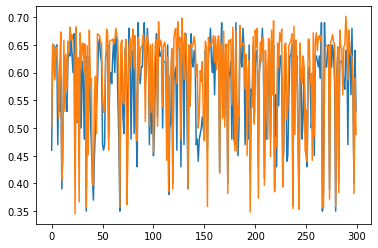

In [ ]:
#Find w and apply on validation data for batch size = 6
w_momentum_8, val_accuracy, train_accuracy = momentum_minibatch(diabetes_train, X_train, y_train, batch_size=6, max_iters=300)
print(w_momentum_8)
plt.plot(val_accuracy)
plt.plot(train_accuracy)

In [ ]:
#Apply on test data
t0 = time.process_time()
w_momentum_8, val_accuracy, train_accuracy = momentum_minibatch(diabetes_train, X_train, y_train, batch_size=6, max_iters=20)
t1 = time.process_time() - t0
print("Time used for convergence:", t1)
yh = np.round(logistic(np.dot(X_TEST,w_momentum_8)),0)
test_accuracy = np.mean(yh == Y_TEST)
print(test_accuracy)

Time used to process one epoch on average: 0.08366943890000159
Time used for convergence: 2.552903308999987
0.6911764705882353


Time used to process one epoch on average: 0.005501695826668159
[ 0.26689311  0.00247917 -0.03152159  0.00217258 -0.00028657 -0.00720792
  0.11034709 -0.030203  ]


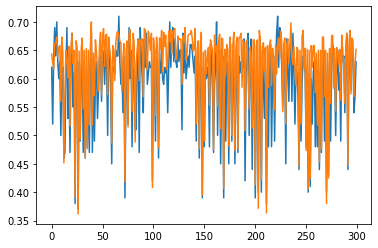

In [ ]:
#Apply on validation data for batch size = 120
w_momentum_100, val_accuracy, train_accuracy = momentum_minibatch(diabetes_train, X_train, y_train, batch_size=100, max_iters=300)
print(w_momentum_100)
plt.plot(val_accuracy)
plt.plot(train_accuracy)

In [ ]:
#Apply on test data
t0 = time.process_time()
w_momentum_100, val_accuracy, train_accuracy = momentum_minibatch(diabetes_train, X_train, y_train, batch_size=100, max_iters=30)
t1 = time.process_time() - t0
print("Time used for convergence:", t1)
yh = np.round(logistic(np.dot(X_TEST,w_momentum_100)),0)
test_accuracy = np.mean(yh == Y_TEST)
print(test_accuracy)

Time used to process one epoch on average: 0.005282075733332666
Time used for convergence: 0.2906920650000018
0.6911764705882353


# Part 2: Text Classification



In [ ]:
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV


## Preprocessing

In [ ]:
fake_news_train = pd.read_csv("/content/drive/My Drive/551A2/fake_news/fake_news_train.csv",index_col=False)
fake_news_test = pd.read_csv("/content/drive/My Drive/551A2/fake_news/fake_news_test.csv",index_col=False)
fake_news_validation = pd.read_csv("/content/drive/My Drive/551A2/fake_news/fake_news_val.csv",index_col=False)

# no missing value 
fake_news_train


,text,label
0,Indian fruit is so important to so many people...,0
1,"FORT WORTH, Texas — Urú Inc. will hold a confe...",0
2,"With three of the four new carriers, the Niger...",0
3,Let's start with the classic annual dividend r...,0
4,Following are some of the major events to have...,1
...,...,...
19995,"Warning: small, petty spoilers for the Game of...",1
19996,Shilpa Shetty will soon make her Bollywood deb...,0
19997,Add a digital black hole image to the Allstate...,0
19998,Share\nThe name W. L. Gore & Associates might ...,1


### Process text


In [ ]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text

fake_news_train['text'] = fake_news_train['text'].apply(preprocessor)

x_train = fake_news_train['text']
y_train = fake_news_train['label']
x_test = fake_news_validation['text']
y_test = fake_news_validation['label']
#x_train,x_test,y_train,y_test = train_test_split(fake_news_train['text'], fake_news_train.label, test_size=0.2, random_state=1)


## Apply Logistic Regression

### Get Best Regularization Strength C


In [ ]:
C_list=[]
val_accuracy_list=[]
train_accuracy_list=[]
for c in [0.01, 0.1, 1, 10, 100]:
  print('--------------------------------')
  print(f"c={c}")
  pipe1 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LogisticRegression(C=c, max_iter=200))])
  model_lr = pipe1.fit(x_train, y_train)
  predicted = model_lr.predict(x_test)
  validation_accuracy = np.mean(predicted == y_test)
  predicted_train = model_lr.predict(x_train)
  train_accuracy = np.mean(predicted_train == y_train)
  C_list.append(c)
  val_accuracy_list.append(validation_accuracy)
  train_accuracy_list.append(train_accuracy)

  print("Accuracy of Logistic Regression Classifier: {}%".format(round(validation_accuracy*100,2)))
  print("\nConfusion Matrix of Logistic Regression Classifier:\n")
  print(confusion_matrix(y_test, predicted))
  print("\nCLassification Report of Logistic Regression Classifier:\n")
  print(classification_report(y_test, predicted))


--------------------------------
c=0.01
Accuracy of Logistic Regression Classifier: 59.9%

Confusion Matrix of Logistic Regression Classifier:

[[   0  802]
 [   0 1198]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       802
           1       0.60      1.00      0.75      1198

    accuracy                           0.60      2000
   macro avg       0.30      0.50      0.37      2000
weighted avg       0.36      0.60      0.45      2000

--------------------------------
c=0.1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of Logistic Regression Classifier: 61.9%

Confusion Matrix of Logistic Regression Classifier:

[[  47  755]
 [   7 1191]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.87      0.06      0.11       802
           1       0.61      0.99      0.76      1198

    accuracy                           0.62      2000
   macro avg       0.74      0.53      0.43      2000
weighted avg       0.72      0.62      0.50      2000

--------------------------------
c=1
Accuracy of Logistic Regression Classifier: 70.7%

Confusion Matrix of Logistic Regression Classifier:

[[ 298  504]
 [  82 1116]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.78      0.37      0.50       802
           1       0.69      0.93      0.79      1198

    accuracy                           0.71      2000
   macro avg       0.74      0.65     

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of Logistic Regression Classifier: 73.95%

Confusion Matrix of Logistic Regression Classifier:

[[ 385  417]
 [ 104 1094]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.79      0.48      0.60       802
           1       0.72      0.91      0.81      1198

    accuracy                           0.74      2000
   macro avg       0.76      0.70      0.70      2000
weighted avg       0.75      0.74      0.72      2000

--------------------------------
c=100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of Logistic Regression Classifier: 73.9%

Confusion Matrix of Logistic Regression Classifier:

[[ 408  394]
 [ 128 1070]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.76      0.51      0.61       802
           1       0.73      0.89      0.80      1198

    accuracy                           0.74      2000
   macro avg       0.75      0.70      0.71      2000
weighted avg       0.74      0.74      0.73      2000



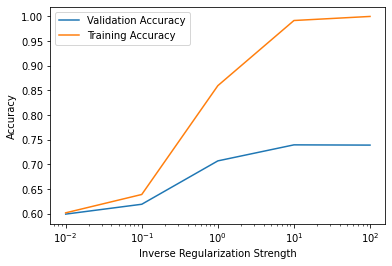

In [ ]:
def showPlot(c_list, val_accuracy_list, train_accuracy_list):
    plt.plot(c_list, val_accuracy_list, label='Validation Accuracy') 
    plt.plot(c_list, train_accuracy_list, label='Training Accuracy')
    plt.xscale("log")
    plt.xlabel("Inverse Regularization Strength")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

showPlot(C_list, val_accuracy_list, train_accuracy_list)

### Test Accuracy

In [ ]:
X_test = fake_news_test['text']
Y_test = fake_news_test['label']
bestC = C_list[val_accuracy_list.index(max(val_accuracy_list))]
pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LogisticRegression(C=bestC, max_iter=200))])
model_lr = pipe.fit(x_train, y_train)
lr_pred = model_lr.predict(X_test)
validation_accuracy = np.mean(lr_pred == Y_test)
print(f"Apply Logistic Regression on test dataset with C={bestC}")
print('----------------------------------------------------------')
print("Accuracy of Logistic Regression Classifier: {}%".format(round(validation_accuracy*100,2)))
print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(Y_test, lr_pred))
print("\nCLassification Report of Logistic Regression Classifier:\n")
print(classification_report(Y_test, lr_pred))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Apply Logistic Regression on test dataset with C=10
----------------------------------------------------------
Accuracy of Logistic Regression Classifier: 71.77%

Confusion Matrix of Logistic Regression Classifier:

[[ 555  675]
 [ 172 1598]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.76      0.45      0.57      1230
           1       0.70      0.90      0.79      1770

    accuracy                           0.72      3000
   macro avg       0.73      0.68      0.68      3000
weighted avg       0.73      0.72      0.70      3000



### Parameter Tuning with Random Search

*   SGD




In [ ]:
from sklearn.linear_model import SGDClassifier
text_sgd = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier())
                     ])

sgd = text_sgd.fit(x_train, y_train)
predicted_sgd = sgd.predict(x_test)
np.mean(predicted_sgd == y_test)

parameters = {
    'clf__loss':["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    'clf__alpha': [1e-7, 1e-5, 1e-3, 1e-2, 1e-1],
    'clf__penalty': ["l2", "l1"],
    }
gs_clf_sgd = RandomizedSearchCV(sgd, parameters, scoring='accuracy', n_jobs=-1, cv=5)
gs_clf_sgd.fit(x_train, y_train)
gs_clf_sgd.predict(x_test)

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
print('Best Score: %s' % gs_clf_sgd.best_score_)
print('Best Hyperparameters: %s' % gs_clf_sgd.best_params_)

#Best Score: 0.732
#Best Hyperparameters: {'clf__penalty': 'none', 'clf__loss': 'log', 'clf__alpha': 1e-05}

Best Score: 0.7302500000000001
Best Hyperparameters: {'clf__penalty': 'l1', 'clf__loss': 'log', 'clf__alpha': 1e-05}


* Logistic Regression

In [ ]:

lg_search = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('lg', LogisticRegression(max_iter=200, random_state=0, warm_start=True))])
parameters = {
        'lg__penalty': ['l1', 'l2'],
        'lg__C':np.logspace(-3,3,20),
        'lg__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        }
gs_clf = RandomizedSearchCV(lg_search, parameters, scoring='accuracy', n_jobs=-1, cv=5)
gs_clf = gs_clf.fit(x_train, y_train)
gs_clf.predict(x_test)

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
print('Best Score: %s' % gs_clf.best_score_)
print('Best Hyperparameters: %s' % gs_clf.best_params_)

#Best score: 0.736, l2, solver=lbfgs, class_weight=none, C=26.3

Best Score: 0.73505
Best Hyperparameters: {'lg__solver': 'liblinear', 'lg__penalty': 'l2', 'lg__C': 54.555947811685144}


### Test Accuracy with best parameters

In [ ]:
pipeline_bestParam_sgd = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lg', SGDClassifier(
                                               alpha=gs_clf_sgd.best_params_['clf__alpha'],
                                               loss=gs_clf_sgd.best_params_['clf__loss'],
                                               penalty = gs_clf_sgd.best_params_['clf__penalty'],
                                               ),
                     )
                     ])
model_best_sgd = pipeline_bestParam_sgd.fit(x_train, y_train)
sgd_pred = pipeline_bestParam_sgd.predict(X_test)
validation_accuracy = np.mean(sgd_pred == Y_test)

print(f"Apply SGD on test dataset with best parameters from Random Search")
print('----------------------------------------------------------')
print("Accuracy of SGD Classifier: {}%".format(round(validation_accuracy*100,2)))
print("\nConfusion Matrix of SGD Classifier:\n")
print(confusion_matrix(Y_test, lr_pred))
print("\nCLassification Report of SGD Classifier:\n")
print(classification_report(Y_test, lr_pred))

Apply SGD on test dataset with best parameters from Random Search
----------------------------------------------------------
Accuracy of SGD Classifier: 71.9%

Confusion Matrix of SGD Classifier:

[[ 555  675]
 [ 172 1598]]

CLassification Report of SGD Classifier:

              precision    recall  f1-score   support

           0       0.76      0.45      0.57      1230
           1       0.70      0.90      0.79      1770

    accuracy                           0.72      3000
   macro avg       0.73      0.68      0.68      3000
weighted avg       0.73      0.72      0.70      3000



In [ ]:
pipeline_bestParam_lr = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lg', LogisticRegression(
                                               C=gs_clf.best_params_['lg__C'],
                                               solver=gs_clf.best_params_['lg__solver'],
                                               penalty = gs_clf.best_params_['lg__penalty'],
                                               max_iter=500,
                                               random_state=0, 
                                               warm_start=True
                                               ),
                     )
                     ])
model_best_lr = pipeline_bestParam_lr.fit(x_train, y_train)
lr_pred = model_best_lr.predict(X_test)
validation_accuracy = np.mean(lr_pred == Y_test)

print(f"Apply Regression on test dataset with best parameters from Random Search")
print('----------------------------------------------------------')
print("Accuracy of Regression Classifier: {}%".format(round(validation_accuracy*100,2)))
print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(Y_test, lr_pred))
print("\nCLassification Report of Logistic Regression Classifier:\n")
print(classification_report(Y_test, lr_pred))

Apply Regression on test dataset with best parameters from Random Search
----------------------------------------------------------
Accuracy of Regression Classifier: 71.93%

Confusion Matrix of Logistic Regression Classifier:

[[ 580  650]
 [ 192 1578]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.75      0.47      0.58      1230
           1       0.71      0.89      0.79      1770

    accuracy                           0.72      3000
   macro avg       0.73      0.68      0.68      3000
weighted avg       0.73      0.72      0.70      3000

